In [107]:
#IMPORT NECESSARY PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from datetime import datetime
import datetime
import CO2_functions
import CO2_Processing
from CO2_Processing import *
from CO2_functions import *
import pickle

In [137]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [2]:
import pickle

# with open('data.pickle', 'wb') as handle:
#     pickle.dump(data2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data.pickle', 'rb') as handle:
#     data = pickle.load(handle)

In [25]:
with open('aug15_aug21_unsampled.pickle', 'rb') as handle:
    data = pickle.load(handle)
d = downsample_and_concatenate(data)
LI = d['LI']
Vent = d['Vent']

Concatenating Picarro Data
Concatenating Multi Data


In [26]:
LI_dsamp = dwn_sample(LI,10)
Mass = pd.concat([LI_dsamp,Vent],axis=1)

In [388]:
def get_kestral_exp(tablename):
    mycursor = sql_connect()
    mycursor.execute("SELECT *\
                        FROM {}\
                        order by Time asc;".format(tablename)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    data = pd.DataFrame(list(data)) #convert imported data to dataframe
    data.columns = ['Time','Kestral_Vel','Temp','PN','Date'] #name columns
    data['Corrected_DT'] = pd.to_datetime(data['Date'].astype(str) +' '+ pd.to_datetime(data['Time']).dt.time.astype(str))
    data.drop(['Time','Date'],axis=1,inplace=True)
    data['EPOCH_TIME'] = pd.DatetimeIndex(data['Corrected_DT']).astype (np.int)/10**9 +21600
    cols = data.columns.drop('Corrected_DT')
    data[cols] = data[cols].apply(pd.to_numeric,errors='coerce')
    return data

def prepare_cup():
    e37_cup = pd.read_csv("../../Data/Bench_Scale/Flux_From_Vent/e37_cup.csv")
    e38_cup = pd.read_csv("../../Data/Bench_Scale/Flux_From_Vent/e38_cup.csv")

    e37_cup['DT'] =  pd.to_datetime(e37_cup['DT'])
    e38_cup['DT'] =  pd.to_datetime(e38_cup['DT'])

    e37_cup.drop(['Unnamed: 0','Date','Time'],axis=1,inplace=True)
    e38_cup.drop(['Unnamed: 0','Date','Time'],axis=1,inplace=True)

    e37_cup.columns = ['Local_DT','Cup_Vel']
    e38_cup.columns = ['Local_DT','Cup_Vel']

    e37_cup['EPOCH_TIME'] = pd.DatetimeIndex(e37_cup['Local_DT']).astype (np.int)/10**9 +21600
    e38_cup['EPOCH_TIME'] = pd.DatetimeIndex(e38_cup['Local_DT']).astype (np.int)/10**9 +21600
    return e37_cup,e38_cup

def correct_exp_drift(cup,kestral):
    ET_cup = get_single_vent_anem_temp_spike(plot_refinement_all([[cup,'Local_DT','Cup_Vel']],'stack')[0],'Cup_Vel')[0]
    ET_kestral = kestral['EPOCH_TIME'][0]
    diff = ET_kestral-ET_cup
    cup['Corrected_DT'] = cup['Local_DT'] + datetime.timedelta(seconds = diff)
    return cup

def get_gaps(kestral):
    gaps = pd.DataFrame()
    gaps['Start'] = kestral.groupby(['PN']).min()['Corrected_DT']
    gaps['End'] = kestral.groupby(['PN']).max()['Corrected_DT']
    gaps['val']=10*np.ones(len(gaps))
    gaps.reset_index(drop=True,inplace=True)
    return gaps

def delete_gaps(cup,kestral,gaps):
    new_cup_df = pd.DataFrame(columns = cup.columns)
    new_kestral_df = pd.DataFrame(columns = kestral.columns)
    for i in range(1,len(gaps)):
        new_cup_df = new_cup_df.append(cup.loc[(cup['Corrected_DT']>=gaps['Start'][i])&(cup['Corrected_DT']<=gaps['End'][i])])
        new_kestral_df = new_kestral_df.append(kestral.loc[(kestral['Corrected_DT']>=gaps['Start'][i])&(kestral['Corrected_DT']<=gaps['End'][i])])
    return new_cup_df,new_kestral_df

def main_exp_func(cup,kestral):
    new_cup = cup.set_index('Corrected_DT').resample('1S').bfill().resample('5s').mean().reset_index().copy()
    new_kestral = kestral.set_index('Corrected_DT').resample('1S').bfill().resample('5s').mean().reset_index().copy()
    gaps = get_gaps(kestral)
    c,k = delete_gaps(new_cup,new_kestral,gaps)
    df = pd.concat([c.set_index('Corrected_DT'),k.set_index('Corrected_DT')],axis=1).reset_index()
    return df

def plot_exps(df,gaps):
    fig,ax = plt.subplots(figsize=(20,10))
    plt.plot(df['Corrected_DT'],df['Cup_Vel'],'o',markersize=3)
    plt.plot(df['Corrected_DT'],df['Kestral_Vel'],'o',markersize=3)
    for i in range(1,len(gaps)):
        plt.axvline(x=gaps['Start'][i],color='r')
        plt.axvline(x=gaps['End'][i],color='r')
    plt.show()

C:\Users\agmey\Anaconda3\envs\CO2_Eddy\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  if __name__ == '__main__':


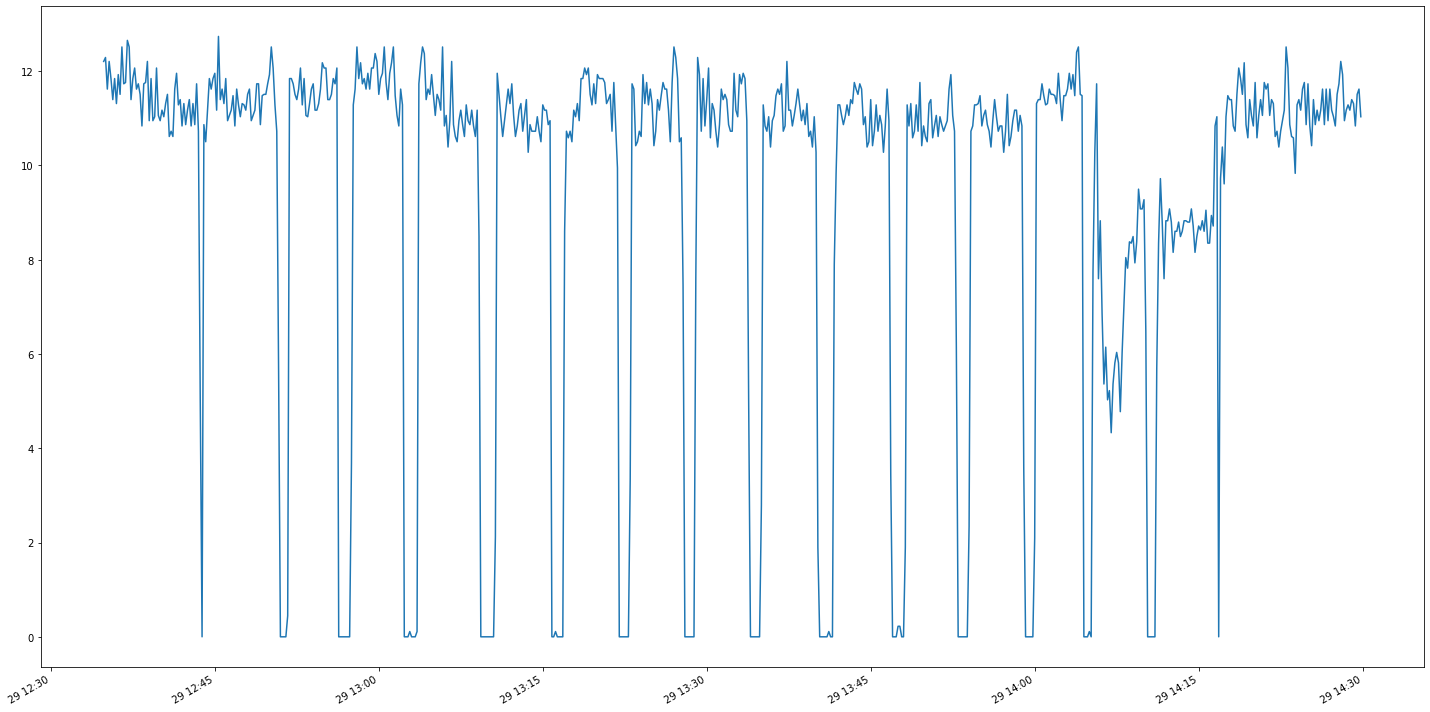

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-20 12:30:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-20 12:45:00


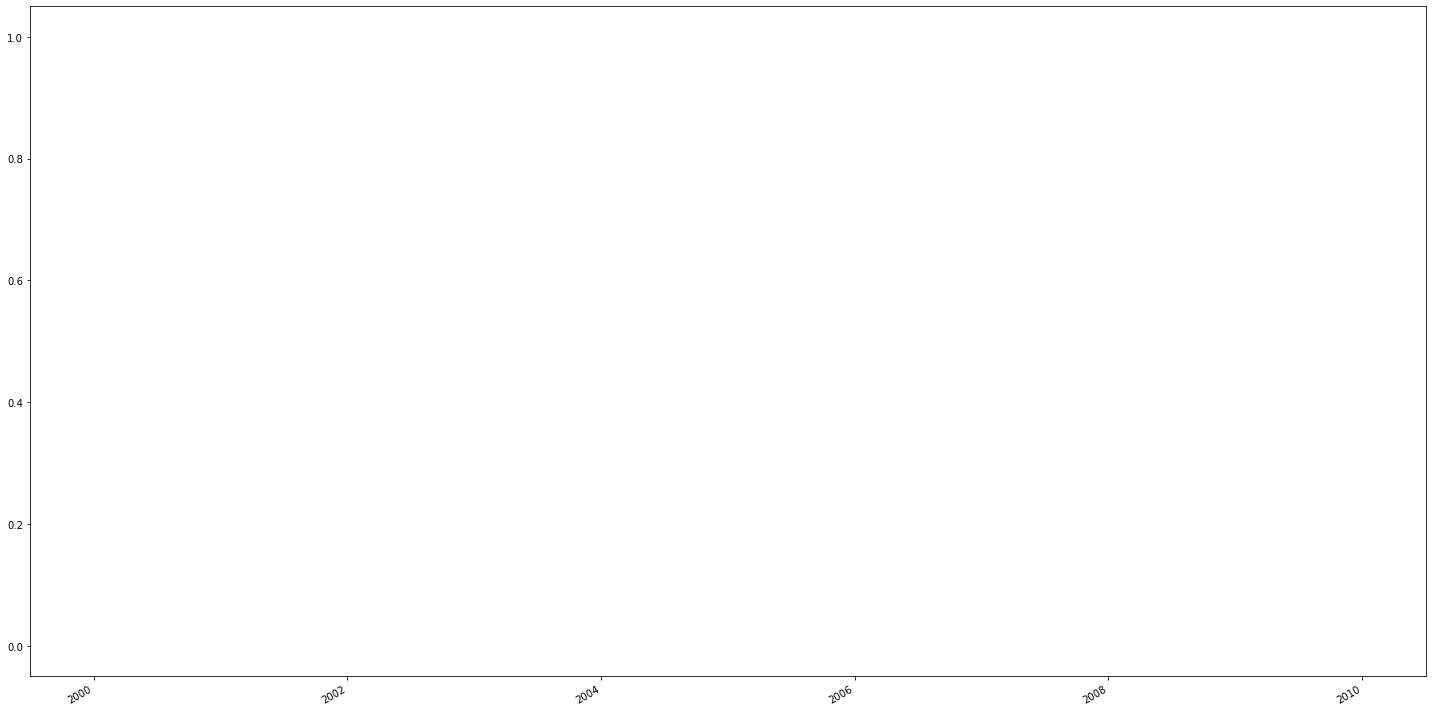

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-29 12:30:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-29 12:45:00


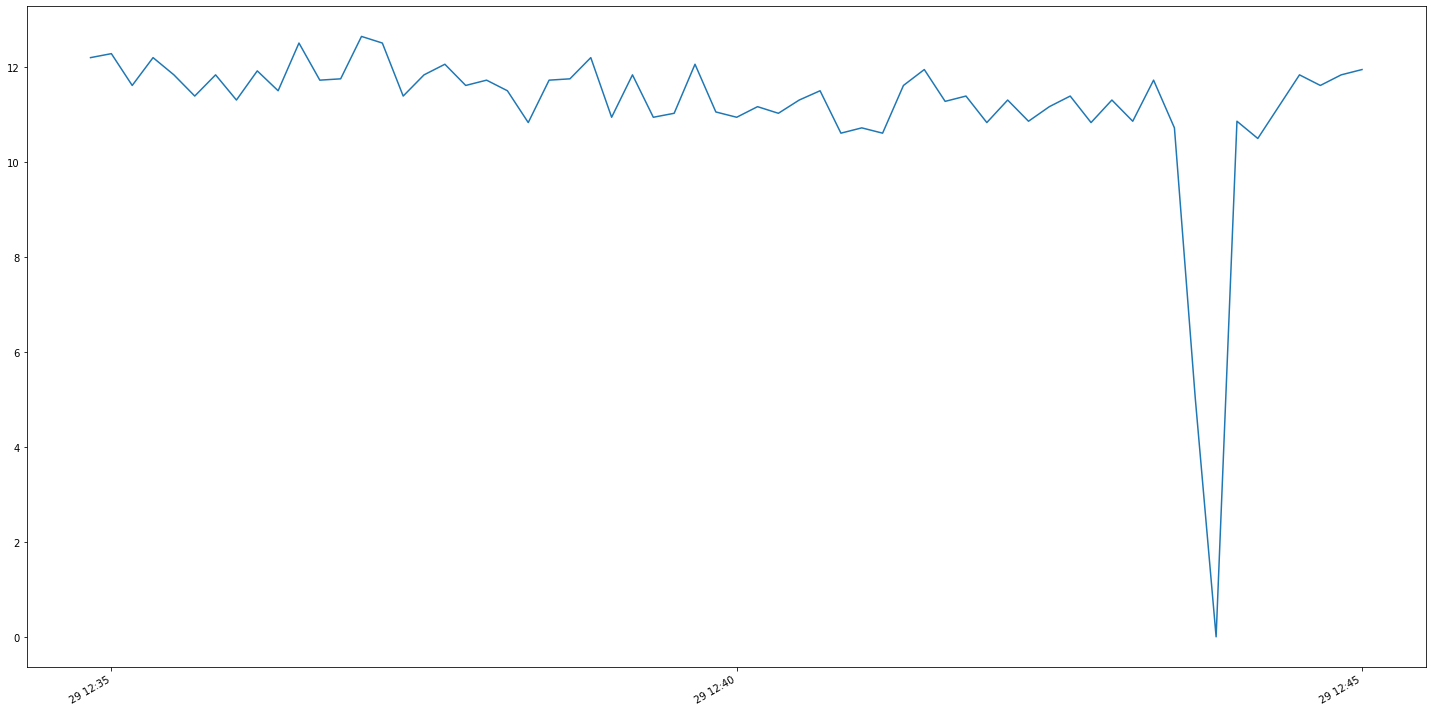

Is this an acceptable range?  y


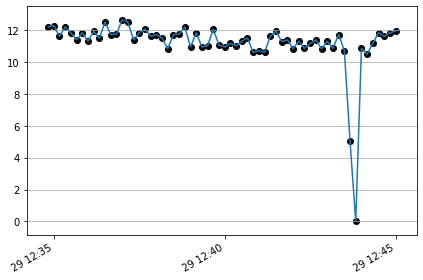

Is this a spike or a dip?  dip
Enter the threshold value which all spikes go below:  8


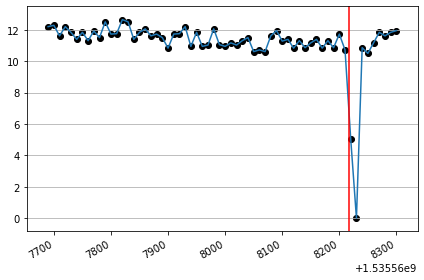

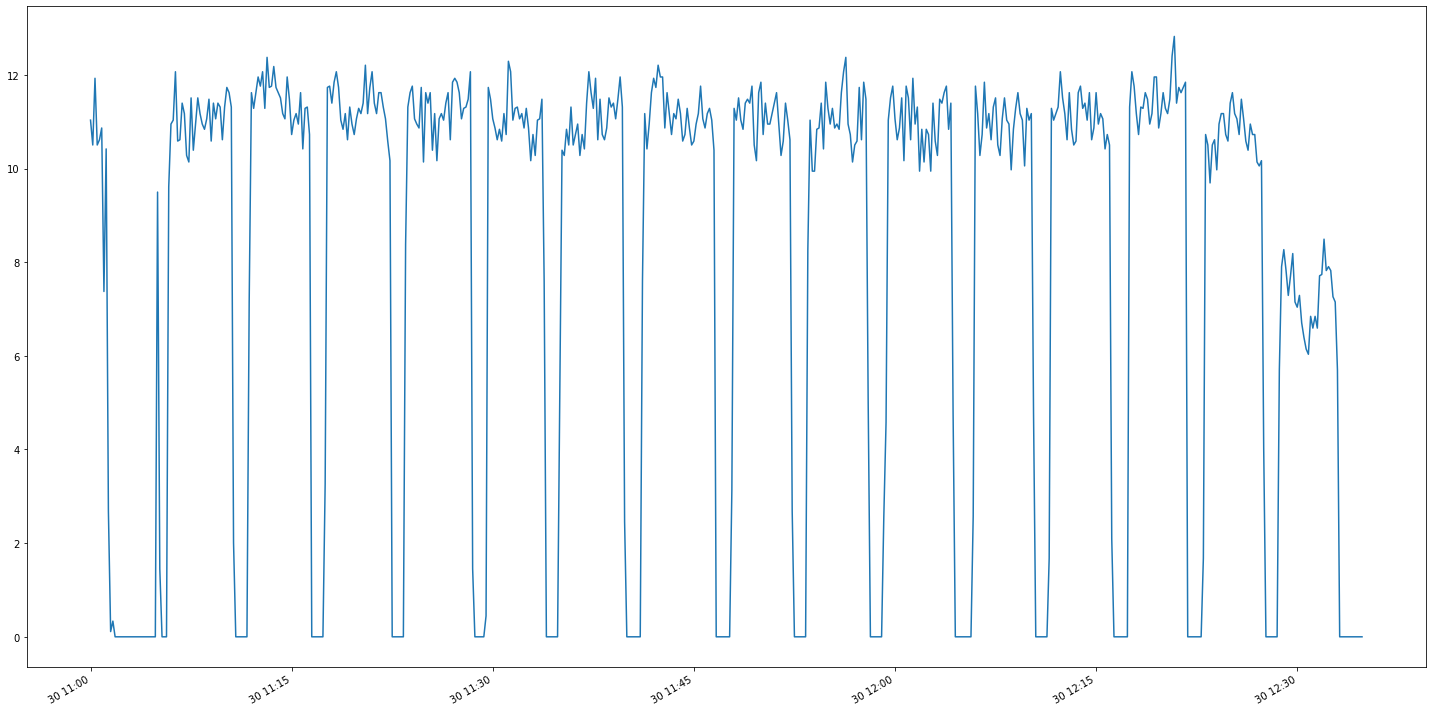

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:10:00


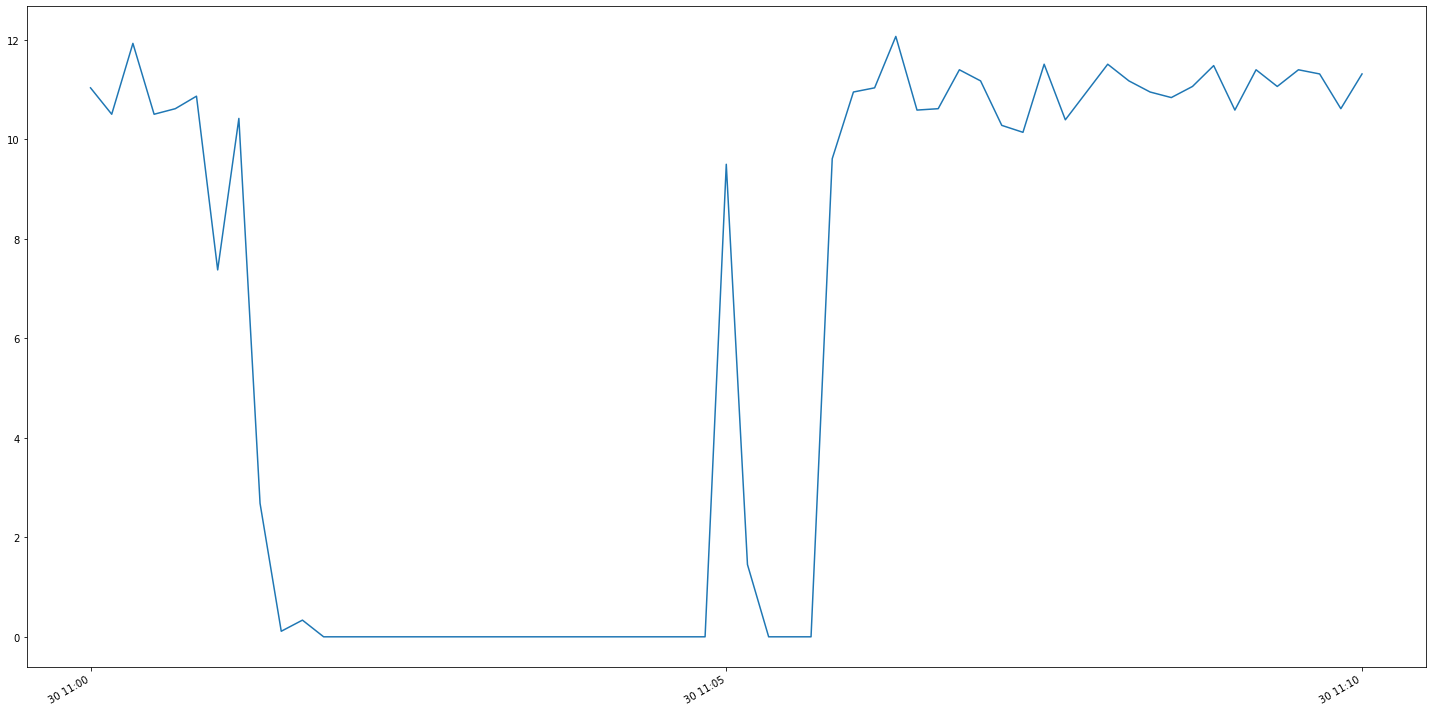

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:02:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:06:00


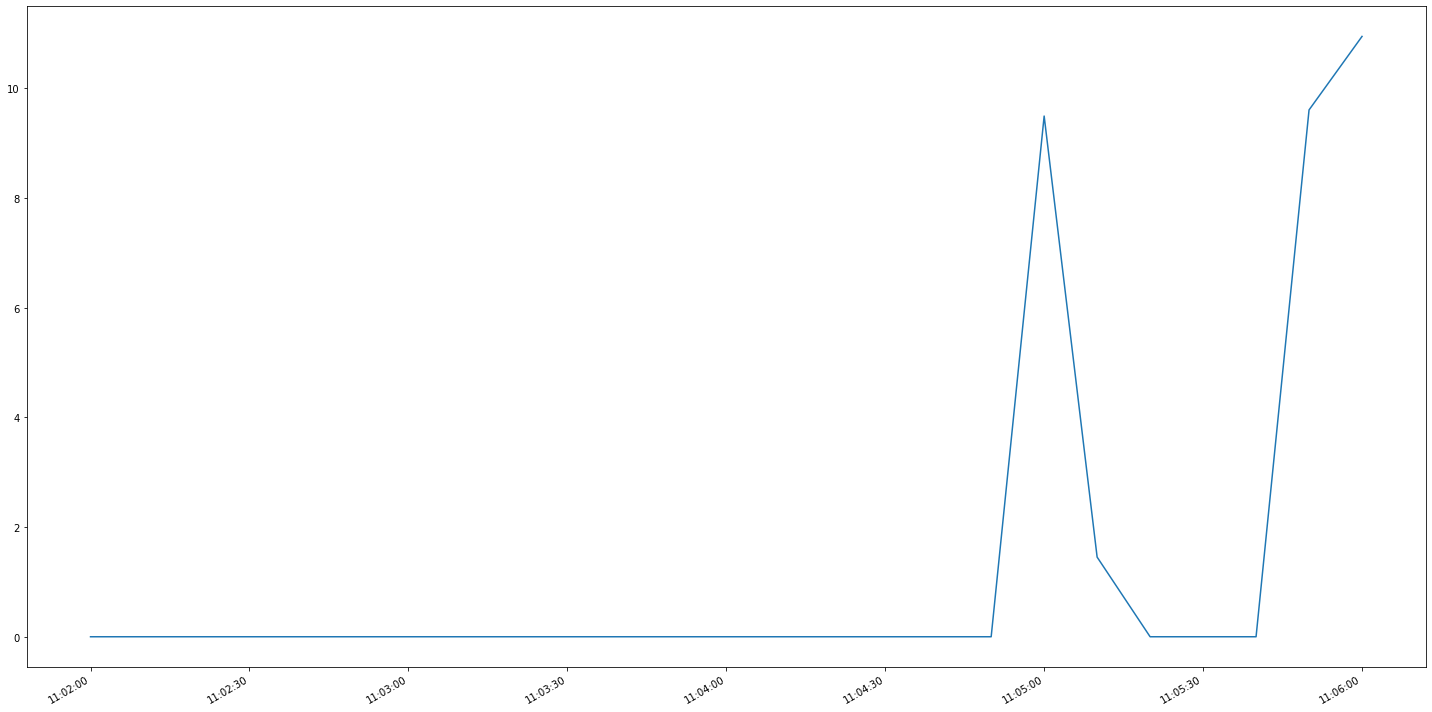

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:00:00


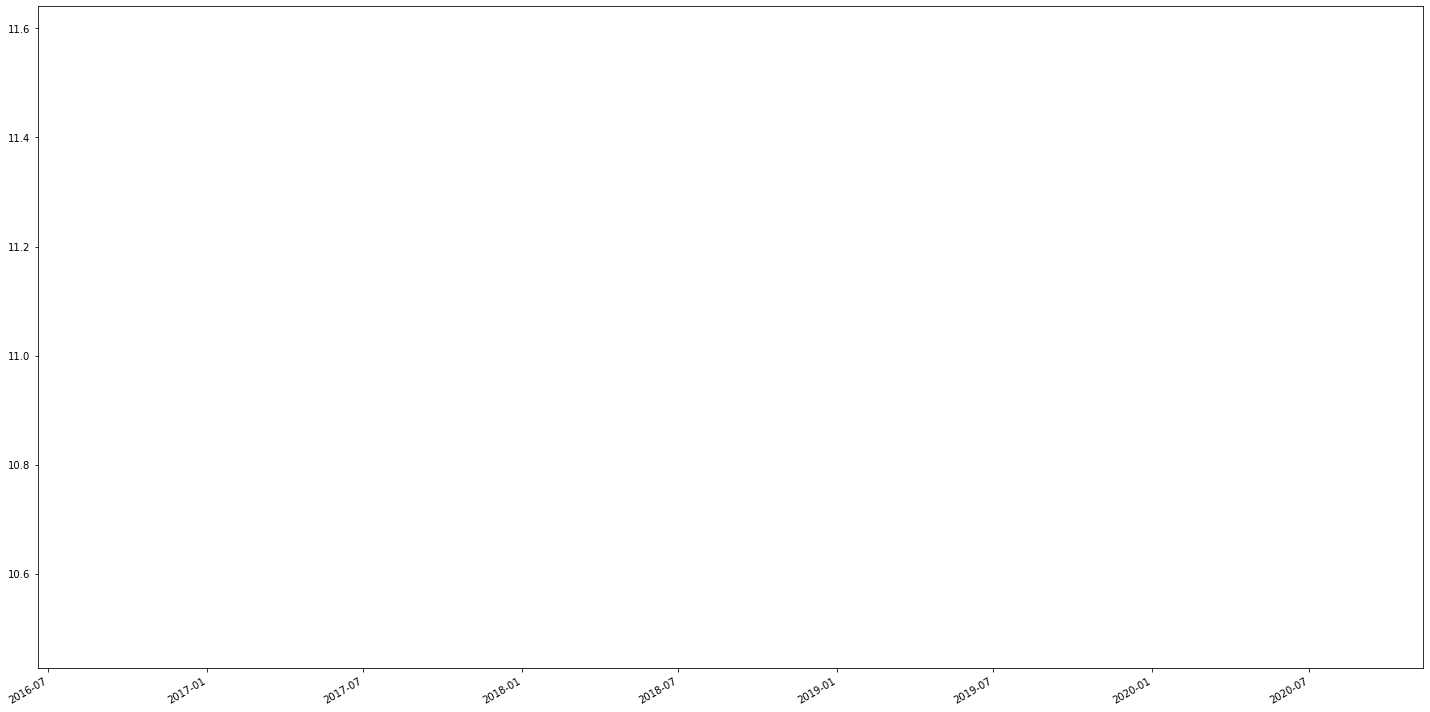

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:03:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2018-08-30 11:05:40


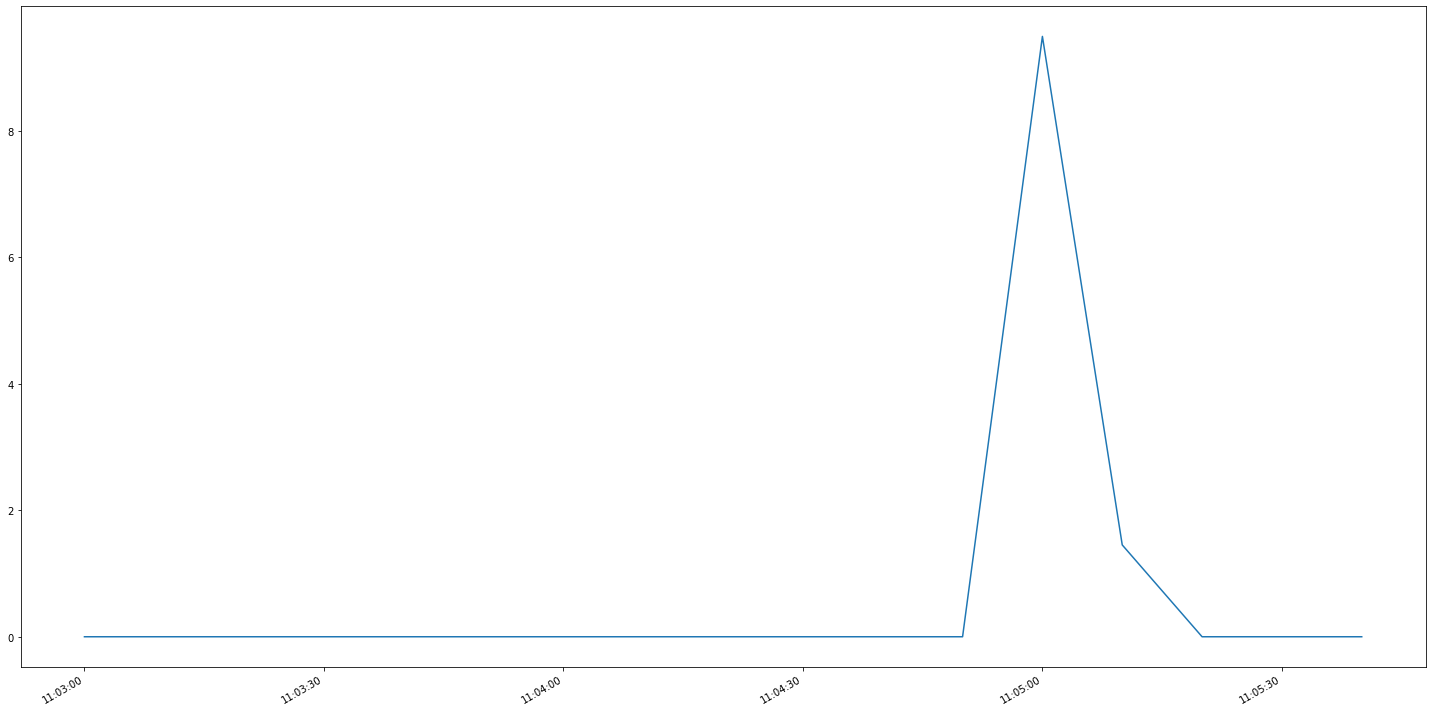

Is this an acceptable range?  y


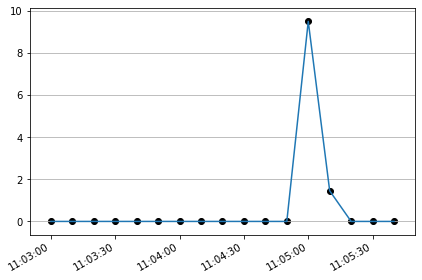

Is this a spike or a dip?  spike
Enter the threshold value which all spikes go above:  1


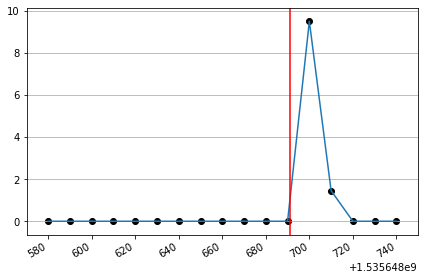

In [390]:
e37_kestral = get_kestral_exp('Exp37')
e38_kestral = get_kestral_exp('Exp38')
e37_cup,e38_cup = prepare_cup()
e37_cup = correct_exp_drift(e37_cup,e37_kestral)
e38_cup = correct_exp_drift(e38_cup,e38_kestral)



In [377]:
def get_gaps(kestral):
    gaps = pd.DataFrame()
    gaps['Start'] = kestral.groupby(['PN']).min()['Corrected_DT']
    gaps['End'] = kestral.groupby(['PN']).max()['Corrected_DT']
    gaps['val']=10*np.ones(len(gaps))
    gaps.reset_index(drop=True,inplace=True)
    return gaps

def delete_gaps(cup,kestral,gaps):
    new_cup_df = pd.DataFrame(columns = cup.columns)
    new_kestral_df = pd.DataFrame(columns = kestral.columns)
    for i in range(1,len(gaps)):
        new_cup_df = new_cup_df.append(cup.loc[(cup['Corrected_DT']>=gaps['Start'][i])&(cup['Corrected_DT']<=gaps['End'][i])])
        new_kestral_df = new_kestral_df.append(kestral.loc[(kestral['Corrected_DT']>=gaps['Start'][i])&(kestral['Corrected_DT']<=gaps['End'][i])])
    return new_cup_df,new_kestral_df

def main_exp_func(cup,kestral):
    new_cup = cup.set_index('Corrected_DT').resample('1S').bfill().resample('5s').mean().reset_index().copy()
    new_kestral = kestral.set_index('Corrected_DT').resample('1S').bfill().resample('5s').mean().reset_index().copy()
    gaps = get_gaps(kestral)
    c,k = delete_gaps(new_cup,new_kestral,gaps)
    df = pd.concat([c.set_index('Corrected_DT'),k.set_index('Corrected_DT')],axis=1).reset_index()
    return df

def plot_exps(df,gaps):
    fig,ax = plt.subplots(figsize=(20,10))
    plt.plot(df['Corrected_DT'],df['Cup_Vel'],'o',markersize=3)
    plt.plot(df['Corrected_DT'],df['Kestral_Vel'],'o',markersize=3)
    for i in range(1,len(gaps)):
        plt.axvline(x=gaps['Start'][i],color='r')
        plt.axvline(x=gaps['End'][i],color='r')
    plt.show()

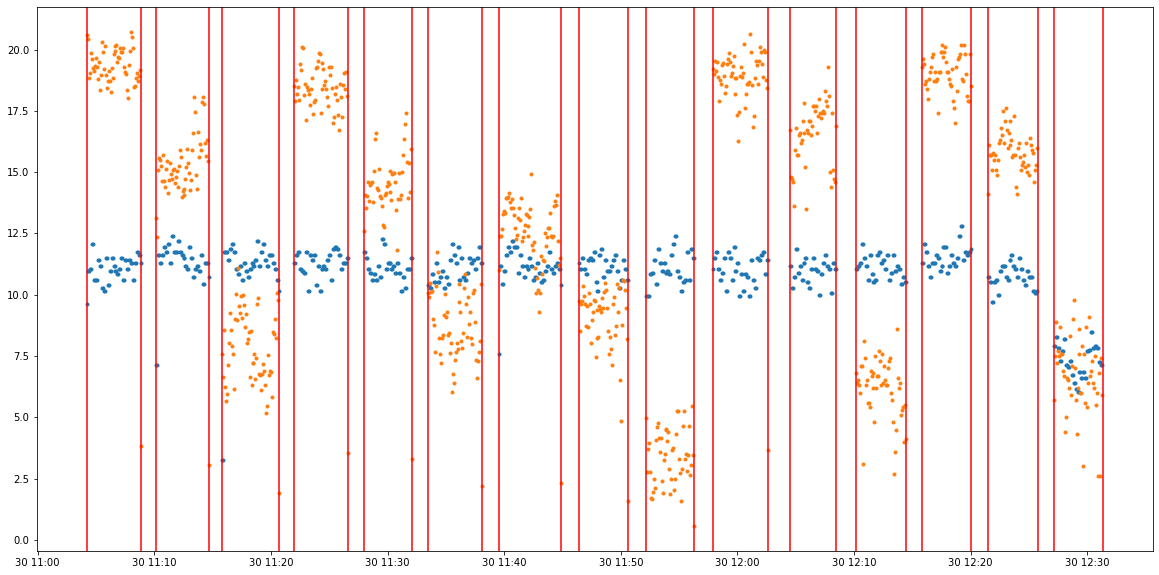

In [391]:
plot_exps(main_exp_func(e38_cup,e38_kestral),get_gaps(e38_kestral))


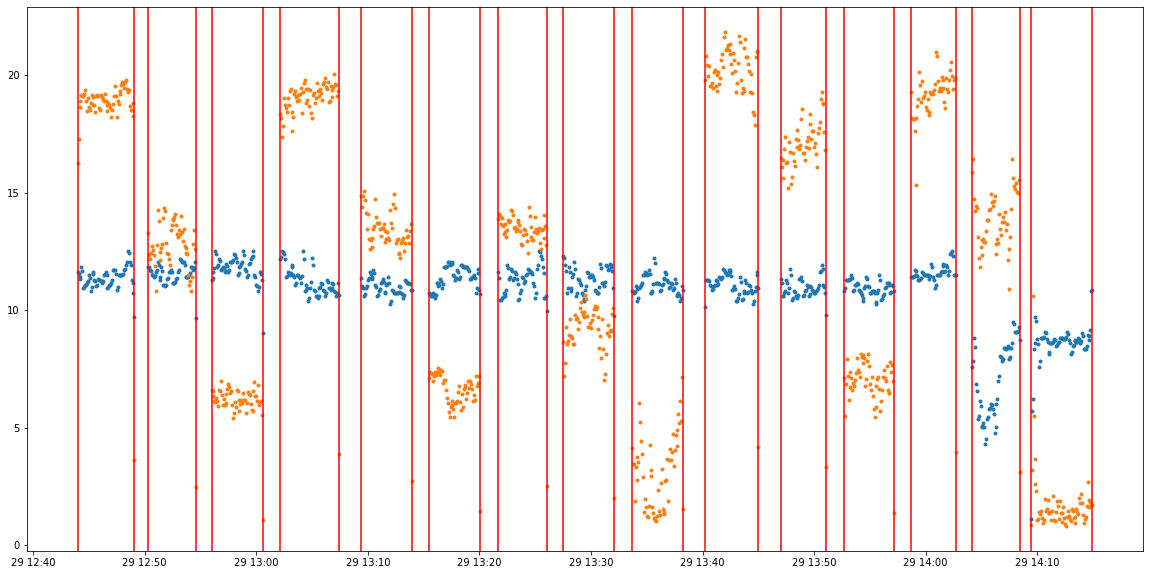

In [380]:
plot_exps(ll,gaps)

In [6]:
all_data38 = []
for i in range(0,len(all_df_38)):
    all_data38.append(all_df_38.loc[all_df_38['PN_int']==i].reset_index())
    
all_data37 = []
for i in range(0,len(all_df_37)):
    all_data37.append(all_df_37.loc[all_df_37['PN_int']==i].reset_index())

In [7]:
i = 14

print('kestral 37 = ',all_data37[i]['Velocity'].mean())
print('cup 37 = ',all_data37[i]['WindSpeed'].mean())
print('kestral 38 = ',all_data38[i]['Velocity'].mean())
print('cup 38 = ',all_data38[i]['WindSpeed'].mean())

kestral 37 =  14.044927536231882
cup 37 =  8.004210185410088
kestral 38 =  15.729411764705882
cup 38 =  10.709661518238578


In [288]:
all_data37[1]['WindSpeed'].mean()

11.433952063434862

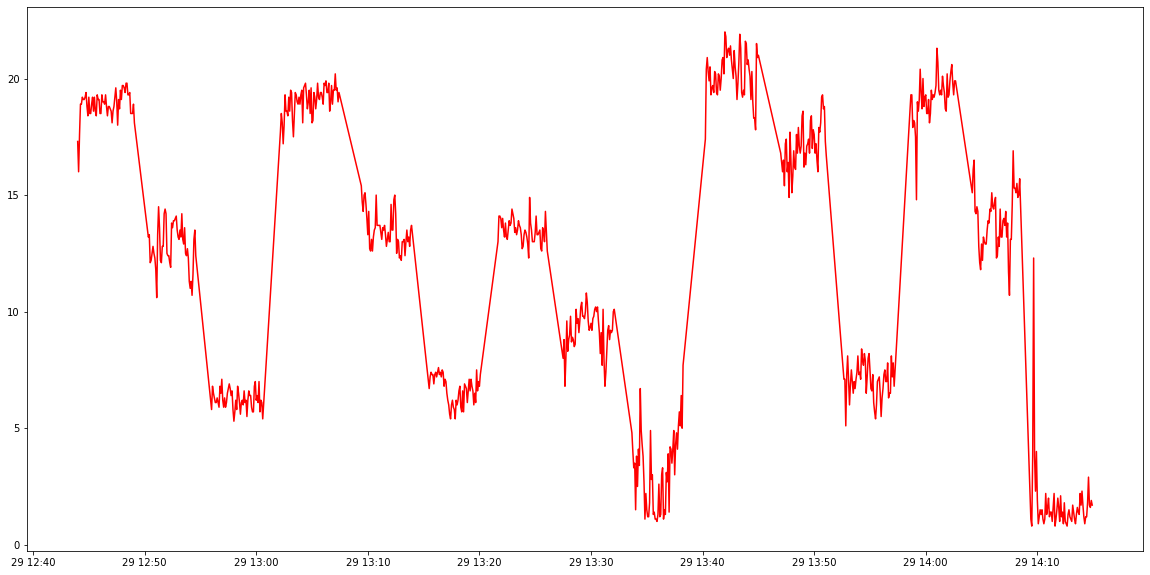

In [12]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(e37_kestral['DT'],e37_kestral['Velocity'],color='red')
#ax.plot(all_df_37.index,all_df_37['Velocity'],color='blue')
# ax.scatter(gaps['Start'],gaps['val'],color="black")
# ax.scatter(gaps['End'],gaps['val'],color="black")



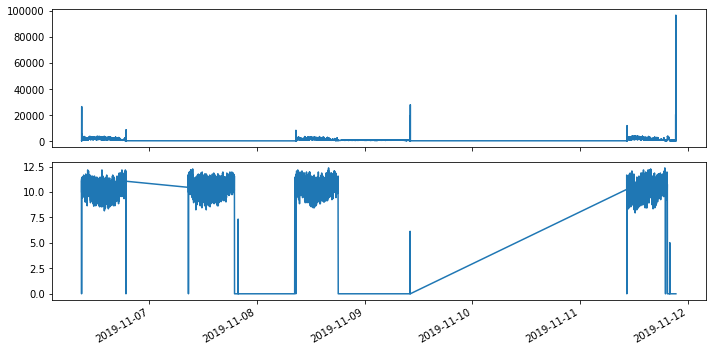

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 08:55:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 09:05:00


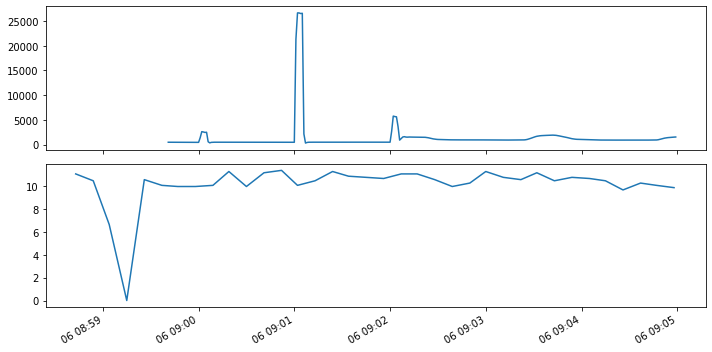

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 18:50:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 19:00:00


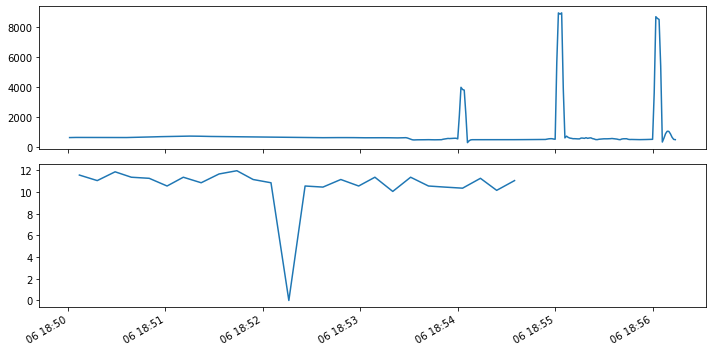

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-08 08:40:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-08 08:46:00


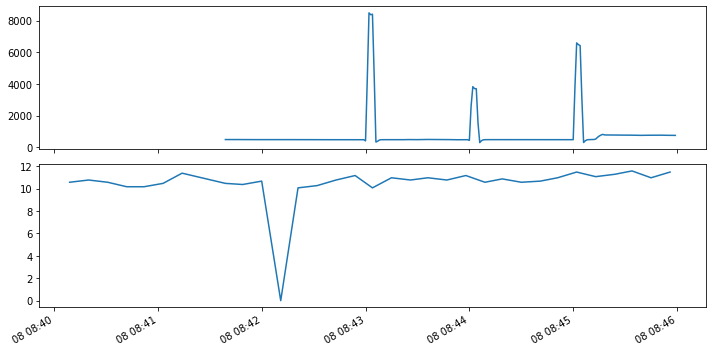

Is this an acceptable range?  y


In [52]:
def mass_flow(LI_df,Vent_anem_df,outer_diam,inner_diam,gas): 
    R = 8.3145
    P = 85194.46
    